## Unsupervised learning on prediction of text difficulty

## pre-settings

In [90]:
# uncomment the following if the following packages have not been installed
#!pip install altair pyLDAvis tqdm dtale transformers spacy scattertext
#!pip install Flask==2.1.0
#!pip install sentence_transformers
#!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
#!pip3 install transformers
#!pip install tqdm

In [91]:
# Disable warning of 3 types
import warnings
# Disable 3 types of warning
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=(FutureWarning))
warnings.filterwarnings("ignore",category=(RuntimeWarning))

In [3]:
from __future__ import print_function
import pandas as pd
import numpy as np

# Text preprocessing
import os,re

#Plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import altair as alt
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()


# Other utils
from tqdm import tqdm  # Progress bar
from datetime import datetime
from dateutil import parser

#EDA tools.
import dtale

# nlp text cleaning
import nltk
import re
import string
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer # or LancasterStemmer, RegexpStemmer, SnowballStemmer

# Transformers
from transformers import pipeline
import ipywidgets as widgets
from transformers import pipeline
from sentence_transformers import SentenceTransformer

# Clustering algorithms
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import LatentDirichletAllocation
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from nltk.stem.snowball import SnowballStemmer

# Visualizing text
import spacy
import scattertext

C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\patri\AppData\Local\Packages\PythonSoftw

In [4]:
%matplotlib inline

## Data Loading

In [5]:
# load training data
train_data_path="./01_data/WikiLarge_Train.csv"
train_data=pd.read_csv(train_data_path)

In [6]:
len(train_data)

416768

In [7]:
train_data.head()

,original_text,label
0,There is manuscript evidence that Austen conti...,1
1,"In a remarkable comparative analysis , Mandaea...",1
2,"Before Persephone was released to Hermes , who...",1
3,Cogeneration plants are commonly found in dist...,1
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1


## Embedding-based clustering analysis

In [8]:
onlinemodel='distiluse-base-multilingual-cased-v2'
embedder = SentenceTransformer(onlinemodel)

###### ! time-consuming block in the below

In [95]:
# It is presumed that the text in difficulty has different features, thus, the embedding will be done separately.
#Create embeddings for data with label ==0
s_train=train_data.sample(n=round(len(train_data)*1))
queries_0 = list(s_train[s_train['label']==0]['original_text'])
queries_1 = list(s_train[s_train['label']==1]['original_text'])
if os.path.exists("./tmp/embeddings_0.csv"):
    query_embeddings_0 = np.loadtxt("./tmp/embeddings_0.csv", delimiter=",")
else:
    # Sampling data given the full train data volume is big
    query_embeddings_0=embedder.encode(queries_0)
    np.savetxt("./tmp/embeddings_0.csv", query_embeddings_0, delimiter=",")

#Create embeddings for data with label ==1
queries_1 = list(s_train[s_train['label']==1]['original_text'])
if os.path.exists("./tmp/embeddings_1.csv"):
    query_embeddings_1 = np.loadtxt("./tmp/embeddings_1.csv", delimiter=",")
else:
    # Sampling data given the full train data volume is big
    query_embeddings_1=embedder.encode(queries_1)
    np.savetxt("./tmp/embeddings_1.csv", query_embeddings_1, delimiter=",")

###### ! time-consuming block in the below

In [ ]:
# It is found that some texts in difficulty are paired with the easy one. Thus, try to 
# create the mapping df between difficult text with easy one
df_text=pd.DataFrame(columns=["queries_1","embeddings_1","queries_0","embeddings_0","sim"])
for i in tqdm(range(len(query_embeddings_1[0:99]))):
    sim=cosine_similarity([query_embeddings_1[i]],query_embeddings_0)
    j=np.argmax(sim)
    new_row=pd.Series(data={"queries_1":queries_1[i],
                            "embeddings_1":query_embeddings_1[i],
                            "queries_0":queries_0[j],
                            "embeddings_0":query_embeddings_0[j],
                            "sim":sim[0][j]
                           }
                            )
    df_text=df_text.append(new_row,ignore_index=True)

In [ ]:
df_text

#### K-means, PCA to perform clustering analysis on 2 types of texts ( with / without difficulty)

In [36]:
# Create clustering dataframe 
def df_clustering(queries, embeddings, labels=None, clusters=2):
    """
        parameters:
        - queries: list of queries
        - embeddings: list of embeddings corresponding to queries
        - clusters: no. of clusters for kmeans
    """
    num_clusters = clusters
    clf = KMeans(n_clusters=num_clusters, 
                max_iter=100, 
                init='k-means++', 
                n_init=1)
    clf.fit_predict(embeddings)
    cluster_assignment = clf.labels_

    cdf=pd.DataFrame(columns=["cluster_id","sentence_id","sentence",'label'])

    cdf['cluster_id']=clf.labels_
    cdf['sentence_id']=[i for i in range(len(clf.labels_))]
    cdf['sentence']=queries
    cdf['label']=labels
                                            
    return cdf

In [40]:
t_queries=queries_0+queries_1
t_labels=[0 for i in range(len(queries_0))]+[1 for i in range(len(queries_1))]
t_embeddings=np.concatenate((query_embeddings_0, query_embeddings_1),axis=0)
df_comparison=df_clustering(t_queries,t_embeddings,t_labels)

In [41]:
df_comparison.head()

,cluster_id,sentence_id,sentence,label
0,0,0,"They recorded two albums together , and severa...",0
1,0,1,"While Marin Ä iliÄ , semifinalist from 2010 de...",0
2,0,2,"However , in International Morse three dits ma...",0
3,0,3,"For Mount Taurus outside Cold Spring , New Yor...",0
4,1,4,1905-1925 Rotherham County F.C.,0


In [42]:
df_comparison.groupby(['cluster_id','label']).count()

sentence_id  sentence
cluster_id label                       
0          0           168543    168543
           1           155226    155226
1          0            39841     39841
           1            53158     53158

##### ! time-consuming block in the below

In [33]:
# Elbow criterion - Determine optimal numbers of clusters by elbow rule.
def elbow_plot(data, maxK=15, seed_centroids=None):
    """
        parameters:
        - data: pandas DataFrame (data to be fitted)
        - maxK (default = 10): integer (maximum number of clusters with which to run k-means)
        - seed_centroids (default = None ): float (initial value of centroids for k-means)
    """
    sse = []
    K= range(1, maxK)
    for k in K:
        if seed_centroids is not None:
            seeds = seed_centroids.head(k)
            kmeans = KMeans(n_clusters=k, max_iter=500, n_init=100, random_state=0, init=np.reshape(seeds, (k,1))).fit(data)
            #data["clusters"] = kmeans.labels_
        else:
            kmeans = KMeans(n_clusters=k, max_iter=300, n_init=100, random_state=0).fit(data)
            #data["clusters"] = kmeans.labels_
        print("k: ", k,"sse: ",kmeans.inertia_)
        # Inertia: Sum of distances of samples to their closest cluster center
        sse.append(kmeans.inertia_)
    plt.figure()
    plt.plot(K,sse,'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    return kmeans.labels_

In [ ]:
# Run Elbow for full training data
elbow_plot(t_embeddings,maxK=5)

k:  1 sse:  382415.25
k:  2 sse:  372549.25
k:  3 sse:  365420.21875


In [ ]:
# Run Elbow for label==0
elbow_plot(query_embeddings_0,maxK=5)

In [96]:
num_clusters = 4
clf = KMeans(n_clusters=num_clusters, 
            max_iter=100, 
            init='k-means++', 
            n_init=1)
clf.fit_predict(query_embeddings_0)
cluster_assignment = clf.labels_

cdf=pd.DataFrame(columns=["cluster_id","sentence_id","sentence"])

for i in range(len(cluster_assignment)):
    new_row=pd.Series(data={"cluster_id":cluster_assignment[i],
                                "sentence_id":i,
                                "sentence":queries_0[i]
                           }
                            )
    cdf=cdf.append(new_row,ignore_index=True)

cdf.head()

,cluster_id,sentence_id,sentence
0,2,0,The Golden Gloves is the name given to competi...
1,2,1,"The DVD featured a two-hour performance , incl..."
2,3,2,"The Generic Universal RolePlaying System , or ..."
3,2,3,Carlos Renato Frederico -LRB- born 21 February...
4,1,4,Bourke is a town and Local Government Area -LR...


##### ! time-consuming block in the below

In [97]:
num_clusters = 4
clf = KMeans(n_clusters=num_clusters, 
            max_iter=100, 
            init='k-means++', 
            n_init=1)
clf.fit_predict(query_embeddings_1)
cluster_assignment = clf.labels_

cdf_1=pd.DataFrame(columns=["cluster_id","sentence_id","sentence"])

for i in range(len(cluster_assignment)):
    new_row=pd.Series(data={"cluster_id":cluster_assignment[i],
                                "sentence_id":i,
                                "sentence":queries_1[i]
                           }
                            )
    cdf_1=cdf_1.append(new_row,ignore_index=True)

cdf_1.head()

,cluster_id,sentence_id,sentence
0,1,0,Some of his notable discoveries include 153 Hi...
1,1,1,"This number excludes redirects , discussion pa..."
2,0,2,"Emperor Ankan was the 27th emperor of Japan , ..."
3,0,3,Microplate Readers -LRB- also known as Plate r...
4,0,4,There are many philosophical issues concerning...


In [98]:
# Using PCA to reduce the dimension to project the result to 2-d scatter plot
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(query_embeddings_0)

df_pca = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

df_pca['sentence']=queries_0
# Combine PCA results with K-means results to see clustering
df_k=df_pca.merge(cdf,right_on=['sentence'],left_on=['sentence'])

In [99]:
# Using PCA to reduce the dimension to project the result to 2-d scatter plot
pca_1 = PCA(n_components=2)
principalComponents = pca_1.fit_transform(query_embeddings_1)

df_pca_1 = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

df_pca_1['sentence']=queries_1
# Combine PCA results with K-means results to see clustering
df_k_1=df_pca_1.merge(cdf,right_on=['sentence'],left_on=['sentence'])

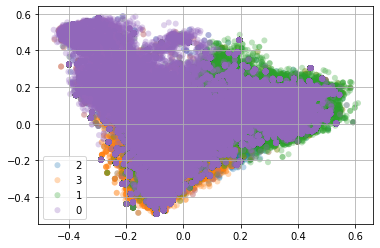

In [106]:
fig, ax = plt.subplots()
ls_clusters=pd.unique(df_k["cluster_id"])
ls_colors=['tab:blue', 'tab:orange', 'tab:green','tab:purple']
#ls_colors=df_k["cluster_id"].astype('category').cat.codes
for id in range(len(ls_clusters)):
    ax.scatter(df_k[df_k['cluster_id']==ls_clusters[id]]['principal component 1'],
               df_k[df_k['cluster_id']==ls_clusters[id]]['principal component 2'], c=ls_colors[id], label=ls_clusters[id],
               alpha=0.3, edgecolors='none')

ax.legend()
ax.grid(True)

plt.show()

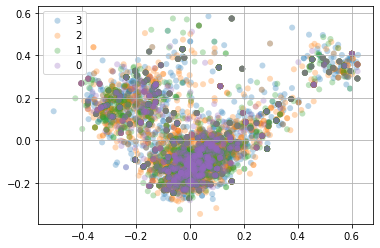

In [107]:
fig, ax = plt.subplots()
ls_clusters=pd.unique(df_k_1["cluster_id"])
ls_colors=['tab:blue', 'tab:orange', 'tab:green','tab:purple']
for id in range(len(ls_clusters)):
    ax.scatter(df_k_1[df_k_1['cluster_id']==ls_clusters[id]]['principal component 1'],
               df_k_1[df_k_1['cluster_id']==ls_clusters[id]]['principal component 2'], c=ls_colors[id], label=ls_clusters[id],
               alpha=0.3, edgecolors='none')

ax.legend()
ax.grid(True)

plt.show()

In [116]:
df_k['label']='0'
df_k_1['label']='1'
df_k_f=pd.concat([df_k,df_k_1])

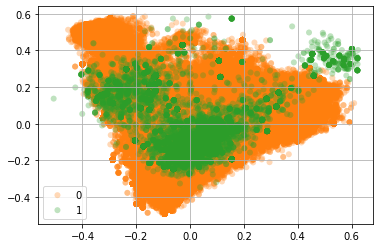

In [119]:
fig, ax = plt.subplots()
ls_labels=pd.unique(df_k_f["label"])
ls_colors=['tab:orange', 'tab:green']
for id in range(len(ls_labels)):
    ax.scatter(df_k_f[df_k_f['label']==ls_labels[id]]['principal component 1'],
               df_k_f[df_k_f['label']==ls_labels[id]]['principal component 2'], c=ls_colors[id], label=ls_labels[id],
               alpha=0.3, edgecolors='none')

ax.legend()
ax.grid(True)

plt.show()

## TF/IDF-based clustering analysis

In [31]:
# tf embeddings
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
dtm_tf_0 = tf_vectorizer.fit_transform(queries_0)
# Using LDA to cluster texts, assuming only 2 types
lda_tf_0 = LatentDirichletAllocation(n_components=2, random_state=0)
lda_tf_0.fit(dtm_tf_0)
pyLDAvis.sklearn.prepare(lda_tf_0, dtm_tf_0, tf_vectorizer)

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.191528  0.0       1        1  50.372196
1     -0.191528  0.0       2        1  49.627804, topic_info=         Term          Freq         Total Category  logprob  loglift
13040     rrb  43980.000000  43980.000000  Default  30.0000  30.0000
8968      lrb  43843.000000  43843.000000  Default  29.0000  29.0000
1780     born   8994.000000   8994.000000  Default  28.0000  28.0000
5967   france   7592.000000   7592.000000  Default  27.0000  27.0000
12484  region   6640.000000   6640.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
2213   called   3336.028059   5799.043527   Topic2  -5.4685   0.1477
13409  season   1572.663649   1795.589361   Topic2  -6.2205   0.5681
10042   music   1742.480523   2686.240739   Topic2  -6.1180   0.2678
14338   state   1777.317755   3310.660274   Topic2  -6.0982   0.0786
14113   south   1773.158683   3455.306926   Topic2  -6.1005   0.0335

[145 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
144        1  0.999895    actor
144        2  0.001147    actor
146        1  0.998307  actress
146        2  0.001764  actress
324        2  0.999760    aisne
...      ...       ...      ...
16564      2  0.968482    world
16601      1  0.999559   writer
16601      2  0.001490   writer
16657      1  0.177488    years
16657      2  0.822772    years

[219 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [43]:
# tf_idf embeddings
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf_0 = tfidf_vectorizer.fit_transform(queries_0)

C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:2019: UserWarning:

Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.



k:  1 sse:  204147.62986296
k:  2 sse:  202237.80082723542
k:  3 sse:  200623.45453388945
k:  4 sse:  199569.0847242216
k:  5 sse:  198989.5101867658


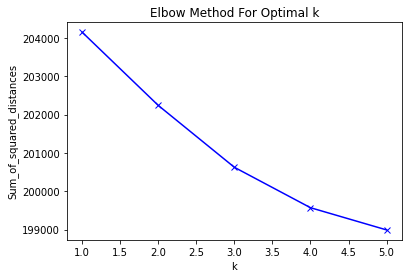

array([3, 3, 3, ..., 3, 3, 3])

In [44]:
elbow_plot(dtm_tfidf_0,maxK=6)

In [45]:
def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df
"""
def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)
"""
def top_mean_feats(X, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_per_cluster(X, y, features, min_tfidf=0.1, top_n=25):
    dfs = []

    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_mean_feats(X, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(15, 9+len(dfs)*6), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(len(dfs),3, i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("cluster = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#7530FF')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.features)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

In [46]:
num_clusters = 2
tfidf_clf_0 = KMeans(n_clusters=num_clusters, 
            max_iter=100, 
            init='k-means++', 
            n_init=1)
tfidf_clf_0.fit_predict(dtm_tfidf_0)

array([0, 0, 0, ..., 0, 0, 0])

In [47]:
tfidf_features = tfidf_vectorizer.get_feature_names()

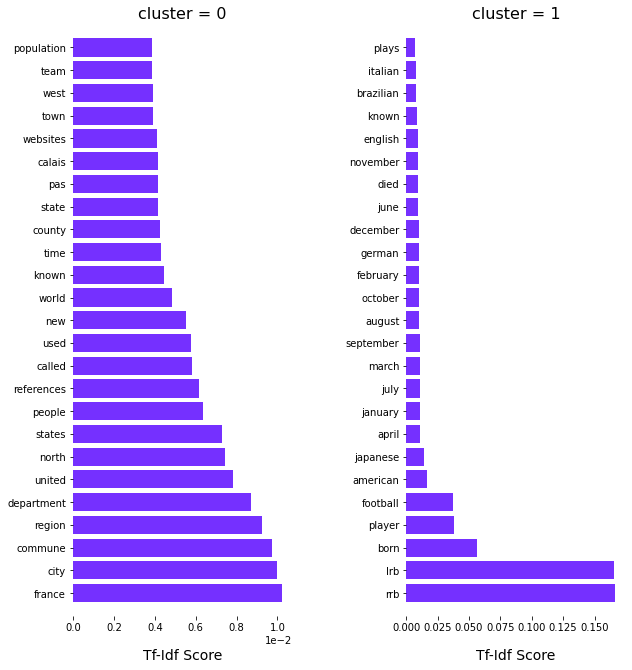

In [48]:
#Use this to print the top terms per cluster with matplotlib.
plot_tfidf_classfeats_h(top_feats_per_cluster(dtm_tfidf_0, tfidf_clf_0.labels_, tfidf_features, 0.1, 25))

In [ ]:
# for TFIDF DTM
lda_tfidf_0 = LatentDirichletAllocation(n_components=2, random_state=0)
lda_tfidf_0.fit(dtm_tfidf_0)
pyLDAvis.sklearn.prepare(lda_tfidf_0, dtm_tfidf_0, tfidf_vectorizer)

In [16]:
# Using scattertext to visualize the text by types
import en_core_web_sm
#import en_core_web_trf  #transformer based embeddings
nlp = en_core_web_sm.load()

In [83]:
df_plot=train_data.sample(10000)
df_plot['label'] =df_plot['label'].astype('str')

In [84]:
corpus = (scattertext.CorpusFromPandas(df_plot,
                                           category_col='label', 
                                           text_col='original_text',
                                           nlp=nlp)
              .build()
              .remove_terms(nlp.Defaults.stop_words, ignore_absences=True)
              )

In [85]:
df = corpus.get_term_freq_df()

In [86]:
df.head()

,0 freq,1 freq
term,,
golden,14,11
gloves,8,1
given,42,31
competitions,3,2
held,19,30


In [87]:
from IPython.display import IFrame 
html = scattertext.produce_scattertext_explorer(
                   corpus,
                   category='0',
                   category_name='non-difficulty',
                   not_category_name=['difficulty'],
                   width_in_pixels=1000,
                   )
open("text_difficulty.html", 'wb').write(html.encode('utf-8'))
IFrame(src="text_difficulty.html", width = 1200, height=700)

In [ ]:
import pytextrank
nlp = en_core_web_sm.load()
nlp.add_pipe("textrank", last=True)

text_df = train_data

text_df['parse']=text_df['original_text'].apply(nlp)
text_df['category']=text_df['label'].apply({0: 'non-difficulty', 1: 'difficulty'})

corpus = st.CorpusFromParsedDocuments(
    text_df,
    category_col='category',
    parsed_col='parse',
    feats_from_spacy_doc=st.PyTextRankPhrases()
).build(
).compact(
    AssociationCompactor(2000, use_non_text_features=True)
)

In [ ]:
term_category_scores = corpus.get_metadata_freq_df('')
print(term_category_scores)